In [459]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from matplotlib import pyplot as plt
from matplotlib import cm

In [475]:
#Set step, paths, pfts and run all

STEP = 2

STEP1_results = 'results_US-Prr_STEP1.csv'
STEP1_sample_matrix = 'sample_matrix_US-Prr_STEP1.csv'

STEP2_results = 'results_US-Prr_STEP2.csv'
STEP2_sample_matrix = 'sample_matrix_US-Prr_STEP2.csv'

pfts=['Black Spruce', 'Moss (Sphagnum dominant)', 'Shrubs (Evergreen Dominant)', 'Tussock Cottongrass', 'Reindeer Lichen']

In [476]:
#if number of pfts != 5 you will have to adjust these values

if STEP == 1:
    target_vars = ['GPP1', 'GPP2', 'GPP3', 'GPP4', 'GPP5']
    
    calib_params = [['cmax', 'cmax.1', 'cmax.2', 'cmax.3', 'cmax.4']] # here for reference
    
    vars_nopft= ['GPP']

if STEP == 2:
    target_vars = ['NPPAll1', 'NPPAll2', 'NPPAll3', 'NPPAll4', 'NPPAll5',
                   'VegCarbonLeaf1', 'VegCarbonLeaf2', 'VegCarbonLeaf3', 'VegCarbonLeaf4', 'VegCarbonLeaf5',
                   'VegCarbonStem1', 'VegCarbonStem3', 'VegCarbonStem4',
                   'VegCarbonRoot1', 'VegCarbonRoot3', 'VegCarbonRoot4']
    
    calib_params = [['nmax', 'nmax.1', 'nmax.2', 'nmax.3', 'nmax.4'], # here for reference
                    ['krb(0)','krb(0).1','krb(0).2','krb(0).3','krb(0).4'],
                    ['krb(1)','krb(1).1','krb(1).2'],
                    ['krb(2)','krb(2).1','krb(2).2']]
    
    vars_nopft  = ['NPPAll', 'VegCarbonLeaf', 'VegCarbonStem', 'VegCarbonRoot']


In [477]:
def Filter(string, substr):
    """ filters list of strings for items containing substring """
    return [str for str in string if
             any(sub in str for sub in substr)]

In [478]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [479]:
def calc_rmse(x,y):
    """ Return rmse where x and y are array-like """
    return ((x-y) ** 2).mean() ** .5

In [480]:
def prep_sa_outputs(results, sample_matrix):
    
    results = pd.read_csv(results, names=target_vars)
    
    # extract targets from last row of results csv
    targets = results.loc[len(results)-1] 
    results = results.loc[0:len(results)-2]
    
    r2s = []
    rmses=[]
    
    #calculate r2s and rmse for individual variables 
    for index, row in results.iterrows():
        
        tgt_r2s = []
        tgt_rmses = []
        
        for target_var in vars_nopft:
            
            results_vars_cols = Filter(results, [target_var])
            tgt_r2s.append(rsquared(row[results_vars_cols], targets[results_vars_cols]))
            tgt_rmses.append(calc_rmse(row[results_vars_cols], targets[results_vars_cols]))  
            
        r2s.append(tgt_r2s)
        rmses.append(tgt_rmses)
        
    # concatenate sample matrix to results
    sample_matrix = pd.read_csv(sample_matrix)
    results[sample_matrix.columns] = sample_matrix
    r2s=np.array(r2s)
    rmses=np.array(rmses)
    
    for idx, name in enumerate(vars_nopft):
        
        results[name + '_r2_raw'] = r2s[:, idx]
        results[name + '_rmse_raw'] = rmses[:, idx]
        
        #scale r2 between min and max
        results[name + '_r2_scaled'] = (results[name + '_r2_raw']-np.nanmin(results[name + '_r2_raw']))/(np.max(results[name + '_r2_raw'])-np.nanmin(results[name + '_r2_raw']))
        
        #scale rmse between min and max
        results[name + '_rmse_scaled'] = (results[name + '_rmse_raw']-np.nanmin(results[name + '_rmse_raw']))/(np.max(results[name + '_rmse_raw'])-np.nanmin(results[name + '_rmse_raw']))
        
        #subrtact scaled rmse from r2 for overall accuracy term
        results[name + '_accuracy'] = (results[name + '_r2_raw']-results[name+'_rmse_scaled'])
    
    #scale r2 and rmse and combine for overall accuracy term
    
    results['overall_accuracy'] = results[Filter(list(results.columns), ['accuracy'])].mean(axis=1)
    results['mean_rmse'] = results[Filter(list(results.columns), ['_rmse_scaled'])].mean(axis=1)
    results['mean_r2'] = results[Filter(list(results.columns), ['_r2_raw'])].mean(axis=1)
    
    return results, targets

In [481]:
results

,GPP1,GPP2,GPP3,GPP4,GPP5,cmax,cmax.1,cmax.2,cmax.3,cmax.4,GPP_r2_raw,GPP_rmse_raw,GPP_r2_scaled,GPP_rmse_scaled,GPP_accuracy,overall_accuracy,mean_rmse,mean_r2
0,316.079498,191.273979,275.022896,87.898190,4.681621,409.045328,335.218419,428.182109,134.000439,18.044745,0.982208,16.526869,0.854279,0.267491,0.714716,0.714716,0.267491,0.982208
1,277.941034,220.859354,270.809405,75.500608,2.927044,363.220165,389.823719,427.132145,118.181765,11.455198,0.923958,34.144608,0.372537,0.694840,0.229118,0.229118,0.694840,0.923958
2,286.562145,213.851221,241.220202,107.324133,2.037153,374.824966,377.188743,380.302165,163.532335,7.947305,0.966388,26.956587,0.723444,0.520482,0.445906,0.445906,0.520482,0.966388
3,298.515524,144.077194,227.153687,109.591829,4.714936,381.761879,257.469519,348.310130,155.974466,17.869024,0.979279,32.833193,0.830058,0.663029,0.316250,0.316250,0.663029,0.979279
4,353.122628,188.230115,287.160593,115.732828,4.956237,450.039117,328.371338,442.968017,171.924520,18.952478,0.990063,16.418217,0.919246,0.264856,0.725207,0.725207,0.264856,0.990063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,291.934259,192.567951,273.434481,130.776681,3.766660,377.936741,337.362081,424.526586,195.061177,14.513790,0.955322,26.827766,0.631923,0.517357,0.437964,0.437964,0.517357,0.955322
996,310.462848,204.720641,222.012854,127.085307,4.682080,403.085850,358.598602,346.800196,190.982364,18.056007,0.976587,23.291852,0.807790,0.431588,0.544999,0.544999,0.431588,0.976587
997,337.632118,174.719362,221.139218,69.238665,4.473404,433.734763,308.463805,344.008451,103.341799,17.237313,0.984603,23.743699,0.874085,0.442548,0.542055,0.542055,0.442548,0.984603
998,325.422696,176.211180,240.523102,127.861141,1.796595,417.557482,308.523927,370.666553,181.873799,6.869213,0.985945,17.019920,0.885189,0.279451,0.706494,0.706494,0.279451,0.985945


In [482]:
if STEP == 1:
    results, targets = prep_sa_outputs(STEP1_results, STEP1_sample_matrix)
if STEP == 2:
    results, targets = prep_sa_outputs(STEP2_results, STEP2_sample_matrix)

print('{} runs'.format(len(results)))


1000 runs


In [483]:
#get indices of top 15 performing parameter sets
perf = np.argsort(results['overall_accuracy'])[::-1]
top = perf[:15].values.tolist()
first = perf[:1].values.tolist()

Text(0.5, 0, 'Mean RMSE across all variables - scaled between min and max')

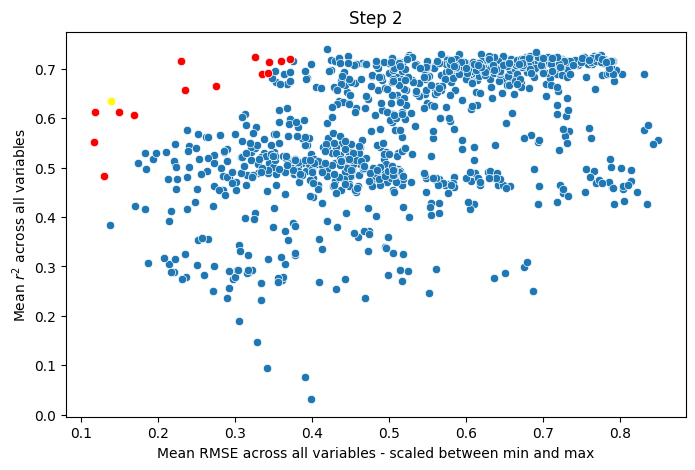

In [484]:
fig, ax = plt.subplots(figsize = (8,5))

sns.scatterplot(data = results, x='mean_rmse', y='mean_r2')
sns.scatterplot(data = results.iloc[top], x='mean_rmse', y='mean_r2', color='red')
sns.scatterplot(data = results.iloc[first], x='mean_rmse', y='mean_r2', color='yellow')

ax.title.set_text('Step {}'.format(STEP))
ax.set_ylabel('Mean $r^2$ across all variables')
ax.set_xlabel('Mean RMSE across all variables - scaled between min and max')

In [485]:
results.columns

Index(['NPPAll1', 'NPPAll2', 'NPPAll3', 'NPPAll4', 'NPPAll5', 'VegCarbonLeaf1',
       'VegCarbonLeaf2', 'VegCarbonLeaf3', 'VegCarbonLeaf4', 'VegCarbonLeaf5',
       'VegCarbonStem1', 'VegCarbonStem3', 'VegCarbonStem4', 'VegCarbonRoot1',
       'VegCarbonRoot3', 'VegCarbonRoot4', 'nmax', 'nmax.1', 'nmax.2',
       'nmax.3', 'nmax.4', 'krb(0)', 'krb(0).1', 'krb(0).2', 'krb(0).3',
       'krb(0).4', 'krb(1)', 'krb(1).1', 'krb(1).2', 'krb(2)', 'krb(2).1',
       'krb(2).2', 'NPPAll_r2_raw', 'NPPAll_rmse_raw', 'NPPAll_r2_scaled',
       'NPPAll_rmse_scaled', 'NPPAll_accuracy', 'VegCarbonLeaf_r2_raw',
       'VegCarbonLeaf_rmse_raw', 'VegCarbonLeaf_r2_scaled',
       'VegCarbonLeaf_rmse_scaled', 'VegCarbonLeaf_accuracy',
       'VegCarbonStem_r2_raw', 'VegCarbonStem_rmse_raw',
       'VegCarbonStem_r2_scaled', 'VegCarbonStem_rmse_scaled',
       'VegCarbonStem_accuracy', 'VegCarbonRoot_r2_raw',
       'VegCarbonRoot_rmse_raw', 'VegCarbonRoot_r2_scaled',
       'VegCarbonRoot_rmse_scaled', '

In [486]:
palette = sns.color_palette("mako", as_cmap=True)

if STEP == 1:
    fig, axes = plt.subplots(2,3, figsize = (10,8))
    fig.suptitle('STEP 1 cmax vs GPP for each PFT')

    axes[0,0].axhline(targets['GPP1'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='cmax', y='GPP1', ax=axes[0,0], legend=False, alpha=0.05)
    sns.scatterplot(data = results.iloc[top], x='cmax', y='GPP1', ax=axes[0,0], color='red', legend=False)
    sns.scatterplot(data = results.iloc[first], x='cmax', y='GPP1', ax=axes[0,0], color='yellow', legend=False)
    axes[0,0].title.set_text(pfts[0])

    axes[0,1].axhline(targets['GPP2'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='cmax.1', y='GPP2', ax=axes[0,1], legend=False, alpha=0.05)
    sns.scatterplot(data = results.iloc[top], x='cmax.1', y='GPP2', ax=axes[0,1], color='red', legend=False)
    sns.scatterplot(data = results.iloc[first], x='cmax.1', y='GPP2', ax=axes[0,1], color='yellow', legend=False)
    axes[0,1].title.set_text(pfts[1])

    axes[0,2].axhline(targets['GPP3'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='cmax.2', y='GPP3', ax=axes[0,2], legend=False, alpha=0.05)
    sns.scatterplot(data = results.iloc[top], x='cmax.2', y='GPP3', ax=axes[0,2], color='red', legend=False)
    sns.scatterplot(data = results.iloc[first], x='cmax.2', y='GPP3', ax=axes[0,2], color='yellow', legend=False)
    axes[0,2].title.set_text(pfts[2])

    axes[1,0].axhline(targets['GPP4'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='cmax.3', y='GPP4', ax=axes[1,0], hue = 'cmax.1', alpha=0.05, palette=palette)
    sns.scatterplot(data = results.iloc[top], x='cmax.3', y='GPP4', ax=axes[1,0], color='red', legend=False)
    sns.scatterplot(data = results.iloc[first], x='cmax.3', y='GPP4', ax=axes[1,0], color='yellow', legend=False)
    axes[1,0].title.set_text(pfts[3])

    axes[1,1].axhline(targets['GPP5'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='cmax.4', y='GPP5', ax=axes[1,1], legend=False, alpha=0.05)
    sns.scatterplot(data = results.iloc[top], x='cmax.4', y='GPP5', ax=axes[1,1], color='red', label='Top 15 runs')
    sns.scatterplot(data = results.iloc[first], x='cmax.4', y='GPP5', ax=axes[1,1], color='yellow', label='Top run')
    axes[1,1].title.set_text(pfts[4])

    axes[1,1].legend(loc='lower right', bbox_to_anchor=(1,0), title='Overall Accuracy')
   
    fig.tight_layout()


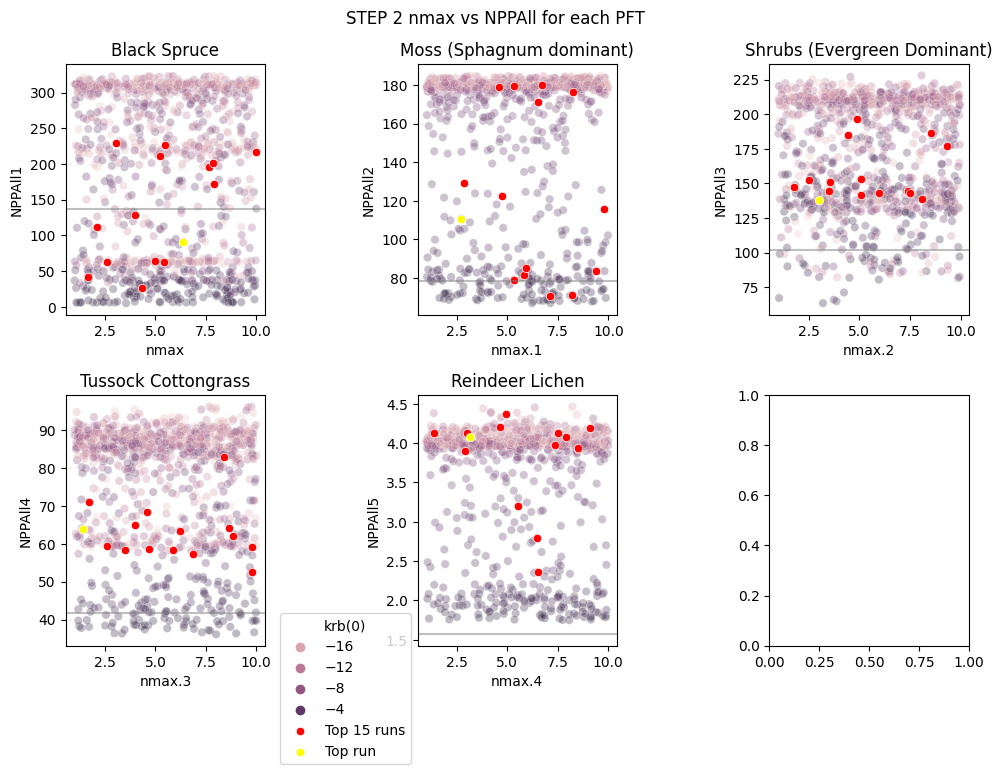

In [489]:
if STEP == 2:
    fig, axes = plt.subplots(2,3, figsize = (10,8))
    fig.suptitle('STEP 2 nmax vs NPPAll for each PFT')

    axes[0,0].axhline(targets['NPPAll1'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='nmax', y='NPPAll1', ax=axes[0,0], hue='krb(0)', alpha=0.3,legend=False)
    sns.scatterplot(data = results.iloc[top], x='nmax', y='NPPAll1', ax=axes[0,0], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='nmax', y='NPPAll1', ax=axes[0,0], color='yellow',legend=False)
    axes[0,0].title.set_text('Black Spruce')

    axes[0,1].axhline(targets['NPPAll2'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='nmax.1', y='NPPAll2', ax=axes[0,1], hue='krb(0).1', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='nmax.1', y='NPPAll2', ax=axes[0,1], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='nmax.1', y='NPPAll2', ax=axes[0,1], color='yellow',legend=False)
    axes[0,1].title.set_text('Moss (Sphagnum dominant)')

    axes[0,2].axhline(targets['NPPAll3'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='nmax.2', y='NPPAll3', ax=axes[0,2], hue='krb(0).2', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='nmax.2', y='NPPAll3', ax=axes[0,2], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='nmax.2', y='NPPAll3', ax=axes[0,2], color='yellow',legend=False)
    axes[0,2].title.set_text('Shrubs (Evergreen Dominant)')

    axes[1,0].axhline(targets['NPPAll4'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='nmax.3', y='NPPAll4', ax=axes[1,0], hue='krb(0).3', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='nmax.3', y='NPPAll4', ax=axes[1,0], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='nmax.3', y='NPPAll4', ax=axes[1,0], color='yellow',legend=False)
    axes[1,0].title.set_text('Tussock Cottongrass')

    axes[1,1].axhline(targets['NPPAll5'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='nmax.4', y='NPPAll5', ax=axes[1,1], hue='krb(0).4', legend=True, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='nmax.4', y='NPPAll5', ax=axes[1,1], color='red',label='Top 15 runs')
    sns.scatterplot(data = results.iloc[first], x='nmax.4', y='NPPAll5', ax=axes[1,1], color='yellow',label='Top run')
    axes[1,1].title.set_text('Reindeer Lichen')

    axes[1,1].legend(loc='lower right', bbox_to_anchor=(0,-.5), title='krb(0)')

    fig.tight_layout()


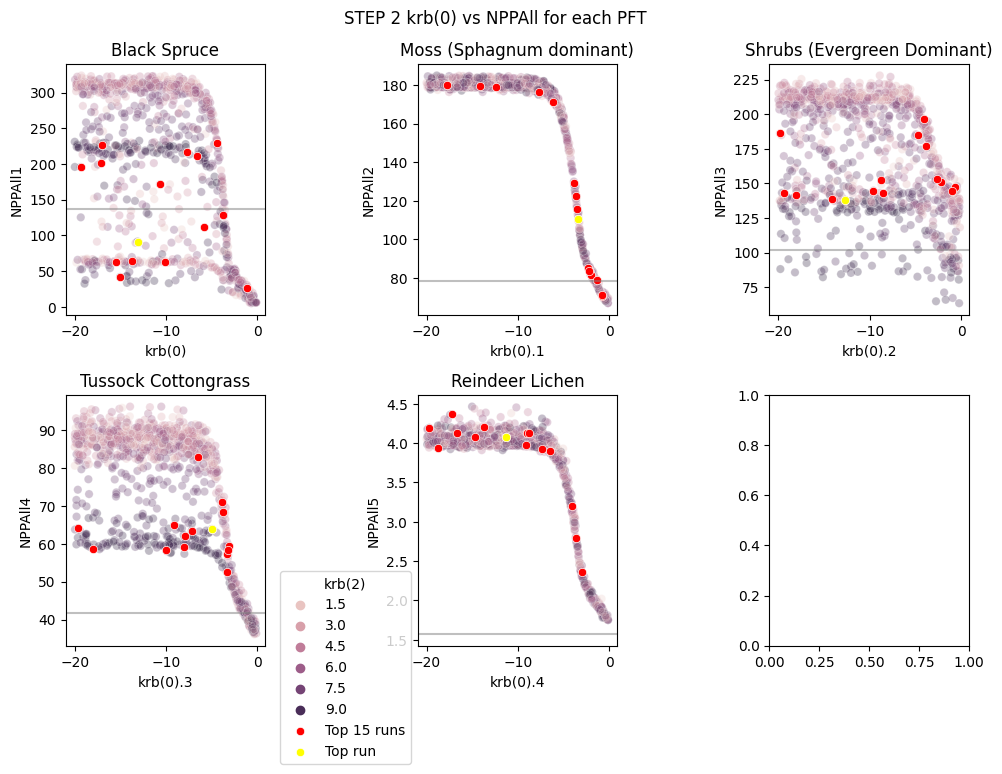

In [490]:
if STEP == 2:
    fig, axes = plt.subplots(2,3, figsize = (10,8))
    fig.suptitle('STEP 2 krb(0) vs NPPAll for each PFT')

    axes[0,0].axhline(targets['NPPAll1'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='krb(0)', y='NPPAll1', ax=axes[0,0], hue='krb(2)', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='krb(0)', y='NPPAll1', ax=axes[0,0], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='krb(0)', y='NPPAll1', ax=axes[0,0], color='yellow',legend=False)
    axes[0,0].title.set_text('Black Spruce')

    axes[0,1].axhline(targets['NPPAll2'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='krb(0).1', y='NPPAll2', ax=axes[0,1], hue='nmax.1', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='krb(0).1', y='NPPAll2', ax=axes[0,1], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='krb(0).1', y='NPPAll2', ax=axes[0,1], color='yellow',legend=False)
    axes[0,1].title.set_text('Moss (Sphagnum dominant)')

    axes[0,2].axhline(targets['NPPAll3'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='krb(0).2', y='NPPAll3', ax=axes[0,2], hue='krb(2).1', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='krb(0).2', y='NPPAll3', ax=axes[0,2], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='krb(0).2', y='NPPAll3', ax=axes[0,2], color='yellow',legend=False)
    axes[0,2].title.set_text('Shrubs (Evergreen Dominant)')

    axes[1,0].axhline(targets['NPPAll4'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='krb(0).3', y='NPPAll4', ax=axes[1,0], hue='krb(2).2', legend=False, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='krb(0).3', y='NPPAll4', ax=axes[1,0], color='red',legend=False)
    sns.scatterplot(data = results.iloc[first], x='krb(0).3', y='NPPAll4', ax=axes[1,0], color='yellow',legend=False)
    axes[1,0].title.set_text('Tussock Cottongrass')

    axes[1,1].axhline(targets['NPPAll5'], color='grey', alpha=0.5)
    sns.scatterplot(data = results, x='krb(0).4', y='NPPAll5', ax=axes[1,1], hue='nmax.4', legend=True, alpha=0.3)
    sns.scatterplot(data = results.iloc[top], x='krb(0).4', y='NPPAll5', ax=axes[1,1], color='red',label='Top 15 runs')
    sns.scatterplot(data = results.iloc[first], x='krb(0).4', y='NPPAll5', ax=axes[1,1], color='yellow',label='Top run')
    axes[1,1].title.set_text('Reindeer Lichen')

    axes[1,1].legend(loc='lower right', bbox_to_anchor=(0,-.5), title='krb(2)')

    fig.tight_layout()